In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from numpy import log
from numpy import pi
from numpy import exp
from scipy.optimize import minimize
import pandas as pd

In [2]:
# Functions for OU model
def simulate_ou( x0, mu, theta, sigma, dt, n ):
  # Simulate an ornstein uhlenbecmu_bar process.    
  # dX_t = μ * (θ − X_t)dt + σ * dB_t 
  # Code 
  x = np.zeros(n)
  x[0] = x0
  exp_minus_mu_deltat = exp(- mu * dt) 
  # Calculate the random term. 
  if mu == 0:
    # Handle the case of mu = 0 i.e. no mean reversion. 
    dWt = np.sqrt(dt) * np.random.randn(n)
  else:
    dWt = np.sqrt((1 - exp(-2*mu*dt))/(2 * mu)) * np.random.randn(n)
  # And iterate through time calculating each price. 
  for t in range(n)[1:]:   
    x[t] = x[t-1] * exp_minus_mu_deltat + theta * (1 - exp_minus_mu_deltat) + sigma * dWt[t]
  return x

def mle_ou( x, dt ):
  # dX_t =μ*(θ − X_t)dt + σ*dB_t
  # mle for a OU process
  n = x.size
  X_x  = np.sum(x[:-1])
  X_y  = np.sum(x[1:])
  X_xx = np.sum(x[:-1]**2)
  X_xy = np.sum(x[:-1]*x[1:])
  X_yy = np.sum(x[1:]**2)

  # estimated long-run mean
  if n*(X_xx - X_xy) - (X_x**2-X_x*X_y) == 0.0:
    theta  = (X_y*X_xx - X_x*X_xy) / 0.001
  else:
    theta  = (X_y*X_xx - X_x*X_xy) / (n*(X_xx - X_xy) - (X_x**2-X_x*X_y))

  # estimated speed of mean reversion
  if X_xx - 2*theta*X_x + n*theta**2 == 0.0:
    mu = - 1/dt * log((X_xy - theta*X_x - theta*X_y + n*theta**2) / 0.001)
  else:
    mu = - 1/dt * log((X_xy - theta*X_x - theta*X_y + n*theta**2) / (X_xx - 2*theta*X_x + n*theta**2))

  # estimated vol
  a = exp(- mu * dt)
  sigma_sq = 2*mu/n/(1 - a**2) * (X_yy - 2*a*X_xy + a**2*X_xx - 2*theta*(1-a)*(X_y-a*X_x) + n*theta**2*(1-a)**2)

  # log-liklihood function value
  sigma_bar_sq = sigma_sq * (1-a**2) / (2*mu)
  ll = -(1/2)*log(2*pi) - log(np.sqrt(sigma_bar_sq)) - 1/(2*n*sigma_bar_sq) * np.sum((x[1:] - a*x[:-1] - theta*(1 - a))**2)
  
  res = {'mu': mu, 'theta': theta, 'sigma': np.sqrt(sigma_sq), 'log-likelihood': ll}
  return res

def get_data(name1: str, name2: str, start, end):
  data1 = yf.download(name1, start=start, end=end, interval = "1d")
  data2 = yf.download(name2, start=start, end=end, interval = "1d")
  s1 = data1['Close']
  s2 = data2['Close']
  return s1, s2

def get_best_ratio_and_ll(s1, s2, dt):
  b_list = (np.arange(400) - 200) / 100
  ll_list = []
  for i in range(400):
    x = s1 - b_list[i] * s2
    result = mle_ou(x, dt)
    ll_list.append(result['log-likelihood']) 
  b_best = b_list[np.argmax(ll_list)]
  ll_best = ll_list[np.argmax(ll_list)]
  return b_best, ll_best

def construct_spread(s1, s2, L, dt):
  '''
  s1: the first stock
  s2: the second storck
  L: the length of historical data used to estimate the best ratio
  '''
  n = s1.size
  x = np.zeros(n - L)
  b_list = np.zeros(n - L)
  ll_list = np.zeros(n - L)
  for i in range(L, n):
    s1_train = s1[i - L : i]
    s2_train = s2[i - L : i]  
    b, ll = get_best_ratio_and_ll(s1_train, s2_train, dt) 
    x[i - L] = s1[i] - b * s2[i]
    b_list[i - L] = b
    ll_list[i - L] = ll
  return s1[L:], s2[L:], x, b_list, ll_list

def dynamic_trade_OU(s1, s2, x, b, init_cash, L, thres):
  '''
  s1: the first stock price series, 1d
  s2: the second storck price series, 1d
  x: spread
  b: best ratio list (s1, s2, x and b have same length)
  init_cash: the amount of money we invest at the beginning
  L: the length of historical data used to compute MA and SD of spreads
  level: the threshold or the width of band
  '''
  n = s1.size
  cash = init_cash
  shares = 0
  num_trades = 0
  equity_list = np.zeros(n) + init_cash
  shares_list = np.zeros(n) 
  for i in range(L, n):
    # Trading criterions
    # Enter position
    if shares == 0 and s1[i] - b[i] * s2[i] < np.average(x[i-L:i]) - thres * np.std(x[i-L:i]):
      shares = cash / s1[i]
      cash = cash - shares * s1[i] + b[i] * shares * s2[i]  
      num_trades += 1

    # Exit position
    if shares > 0 and s1[i] - b[i] * s2[i] > np.average(x[i-L:i]) + thres * np.std(x[i-L:i]):
      cash = cash + shares * s1[i] - b[i] * shares * s2[i]  
      shares = 0
      num_trades += 1

    # Record the change of position
    equity_list[i] = cash + shares * (s1[i] - b[i] * s2[i]) 
    shares_list[i] = shares
 
  return equity_list[L:], shares_list[L:], num_trades

In [3]:
def summarize_total_equity(x):
  '''
  This function is to summarize the statistics of a equity curve
  x: the total equity curve
  '''
  returns = (x[1:] - x[:-1]) / x[:-1]
  daily_return = np.mean(returns) 
  daily_std = np.std(returns)
  daily_sharpe = daily_return / daily_std
  annual_ret = 252 * daily_return
  annual_std = 252**(1/2) * daily_std
  annual_sharpe = 252**(1/2) * daily_sharpe
  max_drawdown = (np.min(x) - x[0]) / x[0]
  cumul_pnl = (x[-1] - x[0]) / x[0]  
  result = {'DailyRet': daily_return,
            'DailyStd': daily_std,
            'DailySharp': daily_sharpe,
            'AnnualRet': annual_ret, 
            'AnnualStd': annual_std,
            'AnnualSharpe': annual_sharpe,
            'MaxDrawdown': max_drawdown,
            'CumulPnL': cumul_pnl,
            }
  return result

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


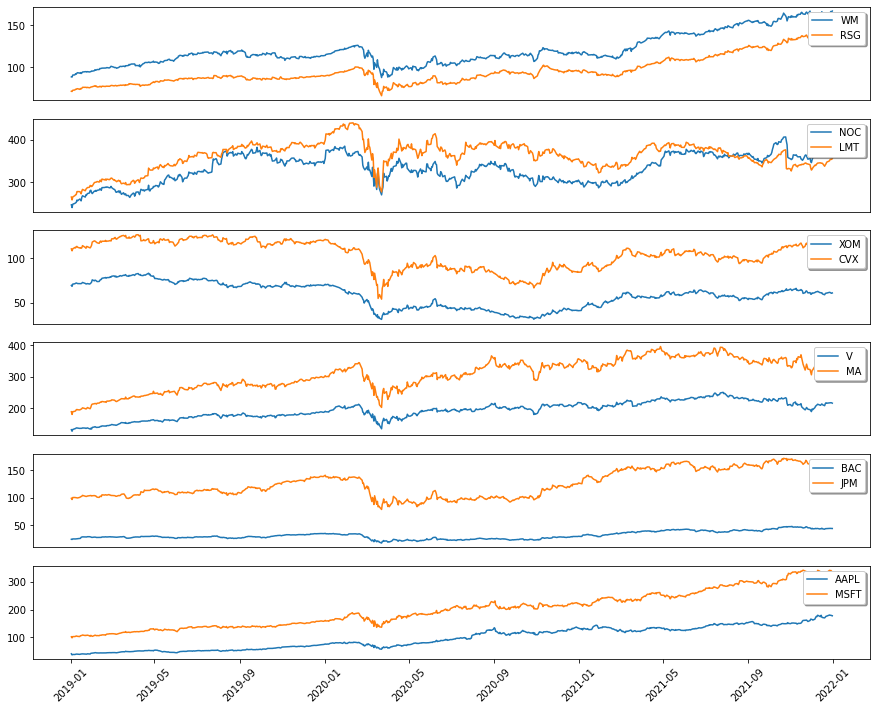

In [4]:
# Download data
dt = 1/252
data = {'WM-RSG':[], 'NOC-LMT':[], 'XOM-CVX':[], 'V-MA':[], 'BAC-JPM':[], 'AAPL-MSFT':[]}
for key in data:
  # get data
  name1, name2 = key.split('-')
  s1, s2 = get_data(name1, name2, "2019-01-01", "2022-01-01")
  # Store s1, s2 to data
  data[key] = pd.concat([s1, s2], keys=['s1', 's2'], axis=1)

# plot the prices of stock pairs
fig, ax = plt.subplots(6)
fig.set_size_inches(15, 12)
i = 0
for key in data:
  name1, name2 = key.split('-')
  ax[i].plot(data[key]['s1'], label=name1)
  ax[i].plot(data[key]['s2'], label=name2)
  ax[i].get_xaxis().set_visible(False)
  ax[i].legend(loc='upper right', shadow=True)
  i += 1
ax[5].get_xaxis().set_visible(True)
plt.xticks(rotation=45)
plt.show()

In [5]:
########### Trading Baseline method: trade equilly ########################
# Formation Period
s1 = {}
s2 = {}
x = {}
b = {}
ll = {}
k = 0
for key in data:
  s1[key], s2[key], x[key], b[key], ll[key] = construct_spread(data[key]['s1'][-534:], data[key]['s2'][-534:], L=252, dt=1/252)
  k += 1  

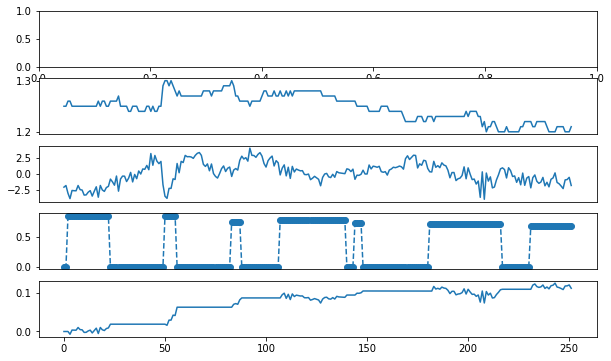

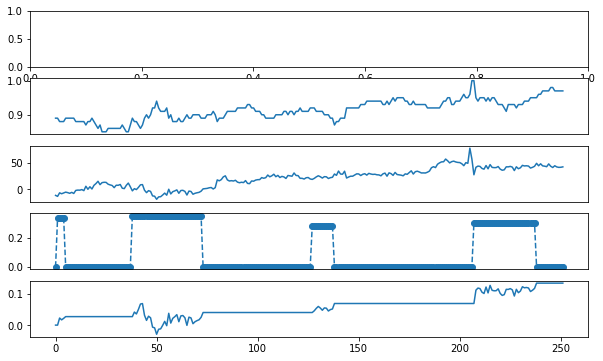

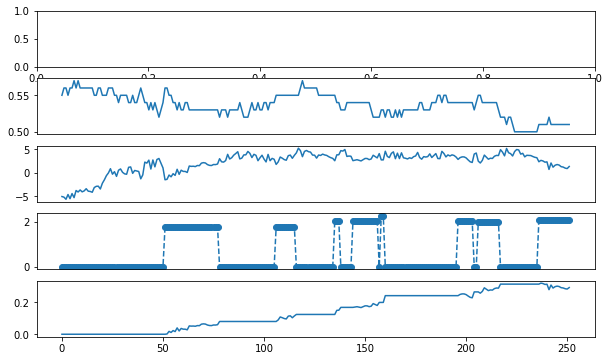

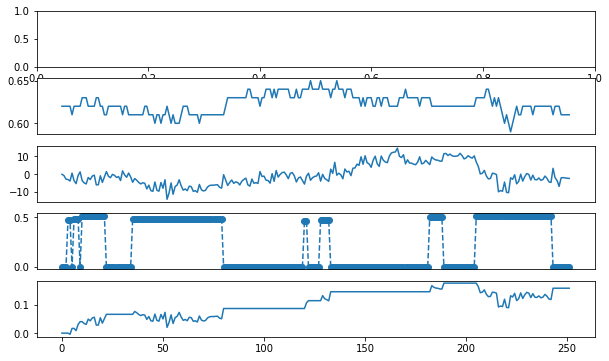

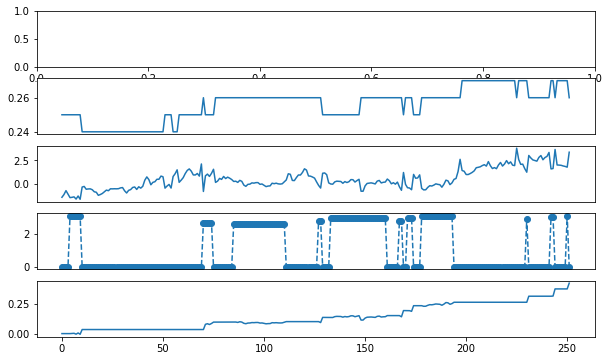

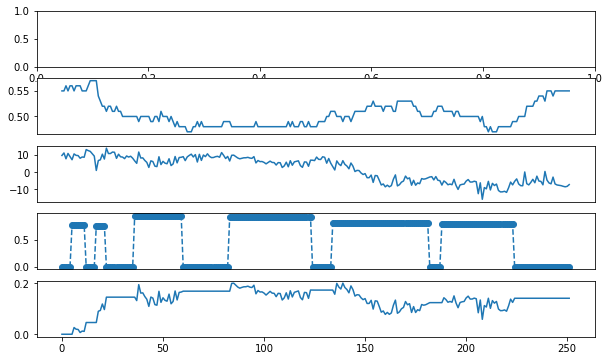

In [6]:
# Trading seperately
thres = 1
n = 252
equity = {}
shares = {}
num_trades = {}
k = 0
for key in data:
    equity[key], shares[key], num_trades[key] = dynamic_trade_OU(s1[key][-n-30:], s2[key][-n-30:], x[key][-n-30:], b[key][-n-30:], 100, 30, thres)
    k += 1
# Visualization
k = 0
for key in data:
  plt.rcParams["figure.figsize"] = (10, 6)
  fig, ax = plt.subplots(5)
  # plot the change of best ratio
  ax[1].plot(np.arange(n), b[key][-n:])
  ax[1].get_xaxis().set_visible(False)
  # plot the spread
  ax[2].plot(np.arange(n), x[key][-n:])
  ax[2].get_xaxis().set_visible(False)
  # plot the position change
  ax[3].scatter(np.arange(n), shares[key][-n:])
  ax[3].plot(np.arange(n), shares[key][-n:], '--')
  ax[3].get_xaxis().set_visible(False)
  # plot equity curve
  ax[4].plot(np.arange(n), equity[key][-n:]/equity[key][-n] - 1)
  k += 1
  plt.show()

In [137]:
# summary of wealth curve
for key in equity:
    print(summarize_total_equity(equity[key]))
    num_trades[key]

{'DailyRet': 0.0004261644541497414, 'DailyStd': 0.003959670528966863, 'DailySharp': 0.1076262408784132, 'AnnualRet': 0.10739344244573483, 'AnnualStd': 0.06285782096038739, 'AnnualSharpe': 1.708513607454091, 'MaxDrawdown': -0.001176684641569998, 'CumulPnL': 0.11068986255331487}
{'DailyRet': 0.0003421089257625892, 'DailyStd': 0.005774521857790174, 'DailySharp': 0.05924454598800485, 'AnnualRet': 0.08621144929217248, 'AnnualStd': 0.09166769265611693, 'AnnualSharpe': 0.9404780113271416, 'MaxDrawdown': -0.007060107849419754, 'CumulPnL': 0.0851071104710932}
{'DailyRet': 0.0002489485815666441, 'DailyStd': 0.006562104585083548, 'DailySharp': 0.03793730781623538, 'AnnualRet': 0.06273504255479431, 'AnnualStd': 0.10417018085596655, 'AnnualSharpe': 0.6022360913583942, 'MaxDrawdown': -0.058041471170350724, 'CumulPnL': 0.05876131598536316}
{'DailyRet': 0.0005533495759894007, 'DailyStd': 0.006093868314086438, 'DailySharp': 0.09080432124046581, 'AnnualRet': 0.13944409314932896, 'AnnualStd': 0.096737160